In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy

% matplotlib inline

import sem
import story_generation
from event_schemas import LinearMLP, BasicRNN, LinearRNN, BatchRNN
import hrr

Using TensorFlow backend.


### functions

In [2]:
# find closest vector to prediction in a pool of objects using euclidean distance
def eucl_match(prediction, objects):
    dists = list(map(lambda x : np.linalg.norm(prediction - x), objects))
    index = dists.index(min(dists)) 
    return objects[index]

In [3]:
# semantic error between prediction and actual components of scene
def euclidean_semantic_error(constants, predicted_scene, semantic_truth):
    # decode fillers of predicted scene from roles
    decode_subj = hrr.decode(predicted_scene, constants['placeholders']['subject'])
    decode_subj_noun = hrr.decode(decode_subj, constants['placeholders']['noun'])
    decode_subj_property = hrr.decode(decode_subj, constants['placeholders']['property'])
    decode_verb = hrr.decode(predicted_scene, constants['placeholders']['verb'])
    decode_obj = hrr.decode(predicted_scene, constants['placeholders']['object'])
    decode_obj_noun = hrr.decode(decode_obj, constants['placeholders']['noun'])
    decode_obj_property = hrr.decode(decode_obj, constants['placeholders']['property'])
    
    subj_noun_error = np.linalg.norm(np.asarray(hrr.normalize(decode_subj_noun)) - np.asarray(hrr.normalize(semantic_truth['subject_noun'])))
    subj_prop_error = np.linalg.norm(np.asarray(hrr.normalize(decode_subj_property)) - np.asarray(hrr.normalize(semantic_truth['subject_property'])))
    verb_error = np.linalg.norm(np.asarray(hrr.normalize(decode_verb)) - np.asarray(hrr.normalize(semantic_truth['verb'])))
    obj_noun_error = np.linalg.norm(np.asarray(hrr.normalize(decode_obj_noun)) - np.asarray(hrr.normalize(semantic_truth['object_noun'])))
    obj_prop_error = np.linalg.norm(np.asarray(hrr.normalize(decode_obj_property)) - np.asarray(hrr.normalize(semantic_truth['object_property'])))
    return subj_noun_error, subj_prop_error, verb_error, obj_noun_error, obj_prop_error

### rnn prediction decoding

It was shown in the decoding demo that the HRR model for scene representation is robust to noise and complex encoding structures. Now we want to check if RNN models can generalize event schemas from events. 2 main questions we want to explore are whether training the RNNs on MSE will improve the semantic accuracy of the predictions as well (with semantic error calculated by averaging the euclidean distances between the decoded components and their generating fillers), and whether the models can generalize across new fillers.

To train the RNN models, we generate a set of events from the same generative schema using different fillers. Currently we're using the coffeeshop fight schema with 2 variable actors, where the properties of the actors determine how the events unfold. We feed in the events one at a time to the network, which trains on the events. After every 50 events are presented, we generate a training (same actors used) and a testing (new actors used) set of evaluation events for the model to predict on, but not to train on; this process tests if minimizing the MSE minimizes the decoding error, as well as whether the structure learning from the training events can be generalized to testing events with new actors.

In [4]:
dim = 150
train_actors, constants = story_generation.initialize_vectors(dim)
test_actors, constants = story_generation.initialize_vectors(dim)
# training[e][s] is a scene, semantic_vectors[e][s] is a map of the fillers used to generate the scene
training, semantic_vectors = story_generation.generate_evaluation_events(train_actors, constants, 5000)

##### online single layer linear activation rnn

In [5]:
dist = 0.0
for i in range(1000):
    a = hrr.embed_2d(1000, None)
    b = hrr.embed_2d(1000, None)
    dist+=np.linalg.norm(hrr.normalize(a)-hrr.normalize(b))
print dist/1000

1.41406175456


In [6]:
demo = LinearRNN(dim)
semantic_errors_train = []
semantic_errors_test = []
euclidean_errors = []
preds = []
for e in range(len(training)):
    event = training[e]
    seen = [hrr.normalize(event[0])]
    eucl_error = 0.0
    pred = []
    for s in range(1, len(event)):
        scene = hrr.normalize(event[s])
        prediction = hrr.normalize(demo.predict(seen))
        eucl_error += np.linalg.norm(prediction - scene)
        seen.append(scene)
        pred.append(prediction)
    euclidean_errors.append(eucl_error / (len(event) - 1))
    demo.train_recurrent(list(map(lambda x : hrr.normalize(x), event)))
    preds.append(pred)
    
    if e % 50 == 0:
        training_eval, train_semantic_vectors = story_generation.generate_evaluation_events(train_actors, constants, 100)
        train_error = 0.0
        for t in range(len(training_eval)):
            train_seen = [hrr.normalize(training_eval[t][0])]
            sem_error = 0.0
            for ts in range(len(training_eval[t])):
                train_prediction = hrr.normalize(demo.predict(train_seen))
                subj_noun_error, subj_prop_error, verb_error, obj_noun_error, obj_prop_error = euclidean_semantic_error(constants, prediction, train_semantic_vectors[t][ts])
                sem_error += (subj_noun_error + subj_prop_error + verb_error + obj_noun_error + obj_prop_error)/5.0
                train_seen.append(hrr.normalize(training_eval[t][ts]))
            train_error += sem_error/len(training_eval[t])
            
        semantic_errors_train.append(train_error/100)
        
        testing, test_semantic_vectors = story_generation.generate_evaluation_events(test_actors, constants, 100)
        test_error = 0.0
        for t in range(len(testing)):
            test_seen = [hrr.normalize(testing[t][0])]
            sem_error = 0.0
            for ts in range(len(testing[t])):
                test_prediction = hrr.normalize(demo.predict(test_seen))
                subj_noun_error, subj_prop_error, verb_error, obj_noun_error, obj_prop_error = euclidean_semantic_error(constants, prediction, test_semantic_vectors[t][ts])
                sem_error += (subj_noun_error + subj_prop_error + verb_error + obj_noun_error + obj_prop_error)/5.0
                test_seen.append(hrr.normalize(testing[t][ts]))
            test_error += sem_error/len(testing[t])
            
        semantic_errors_test.append(test_error/100)

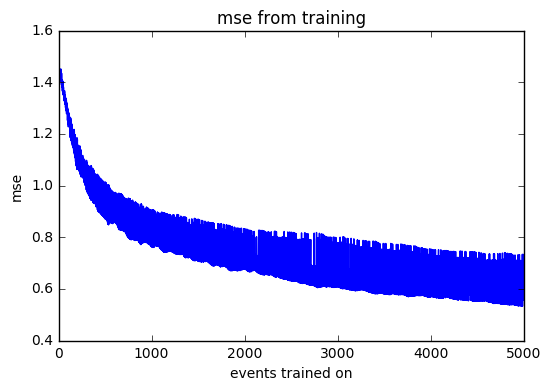

In [7]:
plt.plot(range(len(euclidean_errors)), euclidean_errors)
plt.title("mse from training")
plt.xlabel("events trained on")
plt.ylabel("mse")

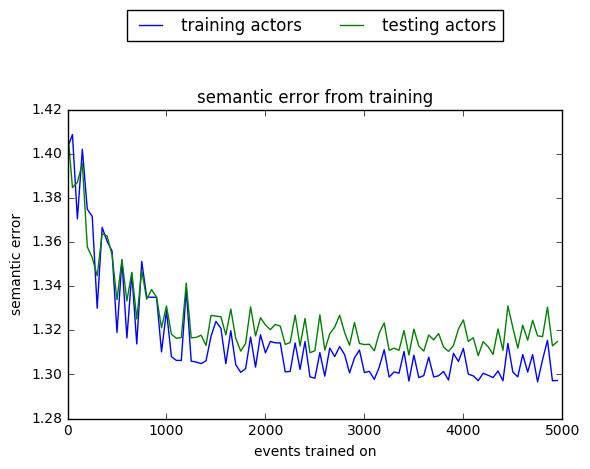

In [8]:
plt.title("semantic error from training")
plt.xlabel("events trained on")
plt.ylabel("semantic error")
plt.plot(list(map(lambda x: 50*x, range(len(semantic_errors_train)))), semantic_errors_train, label="training actors")
plt.plot(list(map(lambda x: 50*x, range(len(semantic_errors_test)))), semantic_errors_test, label="testing actors")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=2)
plt.tight_layout()
plt.show()

##### online multi-layered rnn with 100 units on each hidden layer

In [9]:
demo = BasicRNN(dim, 100, dropout=0.0)
semantic_errors_train = []
semantic_errors_test = []
euclidean_errors = []
preds = []
for e in range(len(training)):
    event = training[e]
    seen = [hrr.normalize(event[0])]
    eucl_error = 0.0
    pred = []
    for s in range(1, len(event)):
        scene = hrr.normalize(event[s])
        prediction = hrr.normalize(demo.predict(seen))
        eucl_error += np.linalg.norm(prediction - scene)
        seen.append(scene)
        pred.append(prediction)
    euclidean_errors.append(eucl_error / (len(event) - 1))
    demo.train_recurrent(list(map(lambda x : hrr.normalize(x), event)))
    preds.append(pred)
    
    if e % 50 == 0:
        training_eval, train_semantic_vectors = story_generation.generate_evaluation_events(train_actors, constants, 100)
        train_error = 0.0
        for t in range(len(training_eval)):
            train_seen = [hrr.normalize(training_eval[t][0])]
            sem_error = 0.0
            for ts in range(len(training_eval[t])):
                train_prediction = hrr.normalize(demo.predict(train_seen))
                subj_noun_error, subj_prop_error, verb_error, obj_noun_error, obj_prop_error = euclidean_semantic_error(constants, prediction, train_semantic_vectors[t][ts])
                sem_error += (subj_noun_error + subj_prop_error + verb_error + obj_noun_error + obj_prop_error)/5.0
                train_seen.append(hrr.normalize(training_eval[t][ts]))
            train_error += sem_error/len(training_eval[t])
            
        semantic_errors_train.append(train_error/100)
        
        testing, test_semantic_vectors = story_generation.generate_evaluation_events(test_actors, constants, 100)
        test_error = 0.0
        for t in range(len(testing)):
            test_seen = [hrr.normalize(testing[t][0])]
            sem_error = 0.0
            for ts in range(len(testing[t])):
                test_prediction = hrr.normalize(demo.predict(test_seen))
                subj_noun_error, subj_prop_error, verb_error, obj_noun_error, obj_prop_error = euclidean_semantic_error(constants, prediction, test_semantic_vectors[t][ts])
                sem_error += (subj_noun_error + subj_prop_error + verb_error + obj_noun_error + obj_prop_error)/5.0
                test_seen.append(hrr.normalize(testing[t][ts]))
            test_error += sem_error/len(testing[t])
            
        semantic_errors_test.append(test_error/100)

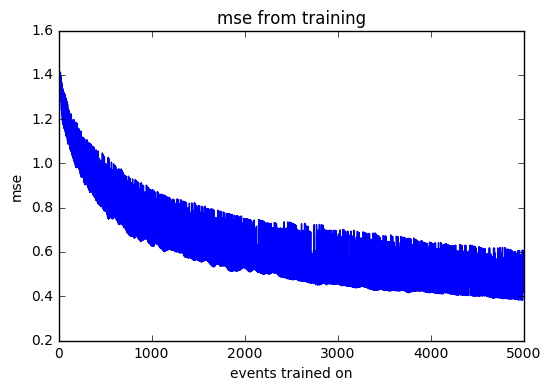

In [10]:
plt.plot(range(len(euclidean_errors)), euclidean_errors)
plt.title("mse from training")
plt.xlabel("events trained on")
plt.ylabel("mse")

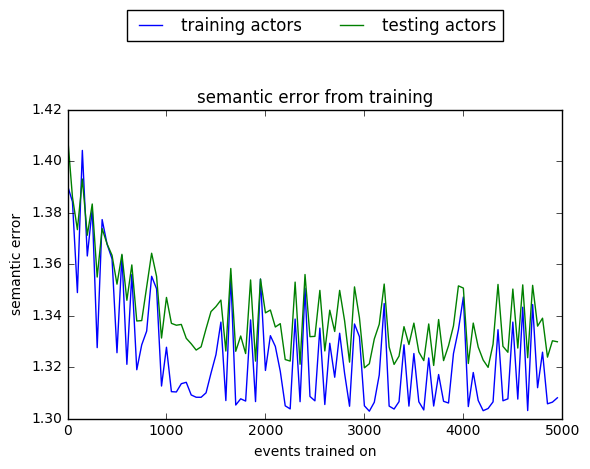

In [11]:
plt.title("semantic error from training")
plt.xlabel("events trained on")
plt.ylabel("semantic error")
plt.plot(list(map(lambda x: 50*x, range(len(semantic_errors_train)))), semantic_errors_train, label="training actors")
plt.plot(list(map(lambda x: 50*x, range(len(semantic_errors_test)))), semantic_errors_test, label="testing actors")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=2)
plt.tight_layout()
plt.show()

##### online multi-layered rnn with 200 units on each hidden layer

In [12]:
demo = BasicRNN(dim, 200, dropout=0.0)
semantic_errors_train = []
semantic_errors_test = []
euclidean_errors = []
preds = []
for e in range(len(training)):
    event = training[e]
    seen = [hrr.normalize(event[0])]
    eucl_error = 0.0
    pred = []
    for s in range(1, len(event)):
        scene = hrr.normalize(event[s])
        prediction = hrr.normalize(demo.predict(seen))
        eucl_error += np.linalg.norm(prediction - scene)
        seen.append(scene)
        pred.append(prediction)
    euclidean_errors.append(eucl_error / (len(event) - 1))
    demo.train_recurrent(list(map(lambda x : hrr.normalize(x), event)))
    preds.append(pred)
    
    if e % 50 == 0:
        training_eval, train_semantic_vectors = story_generation.generate_evaluation_events(train_actors, constants, 100)
        train_error = 0.0
        for t in range(len(training_eval)):
            train_seen = [hrr.normalize(training_eval[t][0])]
            sem_error = 0.0
            for ts in range(len(training_eval[t])):
                train_prediction = hrr.normalize(demo.predict(train_seen))
                subj_noun_error, subj_prop_error, verb_error, obj_noun_error, obj_prop_error = euclidean_semantic_error(constants, prediction, train_semantic_vectors[t][ts])
                sem_error += (subj_noun_error + subj_prop_error + verb_error + obj_noun_error + obj_prop_error)/5.0
                train_seen.append(hrr.normalize(training_eval[t][ts]))
            train_error += sem_error/len(training_eval[t])
            
        semantic_errors_train.append(train_error/100)
        
        testing, test_semantic_vectors = story_generation.generate_evaluation_events(test_actors, constants, 100)
        test_error = 0.0
        for t in range(len(testing)):
            test_seen = [hrr.normalize(testing[t][0])]
            sem_error = 0.0
            for ts in range(len(testing[t])):
                test_prediction = hrr.normalize(demo.predict(test_seen))
                subj_noun_error, subj_prop_error, verb_error, obj_noun_error, obj_prop_error = euclidean_semantic_error(constants, prediction, test_semantic_vectors[t][ts])
                sem_error += (subj_noun_error + subj_prop_error + verb_error + obj_noun_error + obj_prop_error)/5.0
                test_seen.append(hrr.normalize(testing[t][ts]))
            test_error += sem_error/len(testing[t])
            
        semantic_errors_test.append(test_error/100)

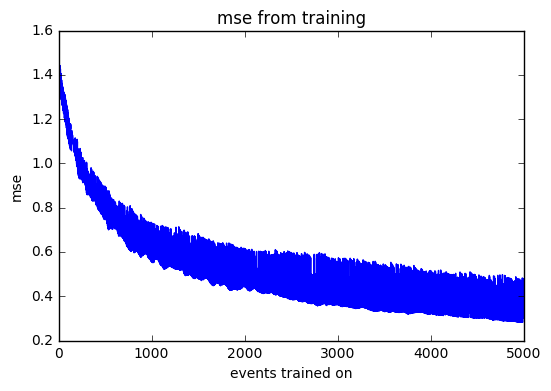

In [13]:
plt.plot(range(len(euclidean_errors)), euclidean_errors)
plt.title("mse from training")
plt.xlabel("events trained on")
plt.ylabel("mse")

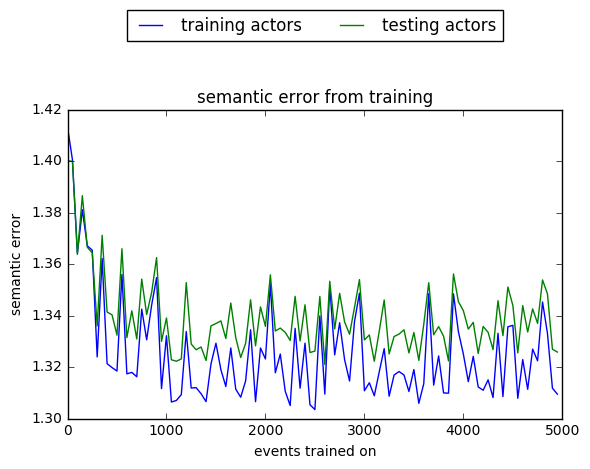

In [14]:
plt.title("semantic error from training")
plt.xlabel("events trained on")
plt.ylabel("semantic error")
plt.plot(list(map(lambda x: 50*x, range(len(semantic_errors_train)))), semantic_errors_train, label="training actors")
plt.plot(list(map(lambda x: 50*x, range(len(semantic_errors_test)))), semantic_errors_test, label="testing actors")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=2)
plt.tight_layout()
plt.show()

### identifying error sources

The training lowers the euclidean distance between the predicted scene and the actual scene, but there is a much weaker effect on semantic error; this is true even on the training evaluation set, which suggests an issue with learning the structure of the event on top of the issue of generalizing to new fillers. 

To better understand this issue we break down the semantic error into its components: the semantic errors of the subject noun, subject property, verb, object noun, and object property. While the semantic error drops for the subject noun and subject property there is virtually no change for the other roles, which explains why the semantic error decreases clearly but not significantly. 

In [15]:
demo = BasicRNN(dim, 100, dropout=0.0)
semantic_errors = {}
semantic_errors['subj_noun'] = []
semantic_errors['subj_prop'] = []
semantic_errors['verb'] = []
semantic_errors['obj_noun'] = []
semantic_errors['obj_prop'] = []
euclidean_errors = []
preds = []
for e in range(len(training)):
    event = training[e]
    seen = [hrr.normalize(event[0])]

    sn_error = 0.0
    sp_error = 0.0
    v_error = 0.0
    on_error = 0.0
    op_error = 0.0
    
    eucl_error = 0.0
    pred = []
    for s in range(1, len(event)):
        scene = hrr.normalize(event[s])
        prediction = hrr.normalize(demo.predict(seen))
        subj_noun_error, subj_prop_error, verb_error, obj_noun_error, obj_prop_error = euclidean_semantic_error(constants, prediction, semantic_vectors[e][s])
        
        sn_error += subj_noun_error
        sp_error += subj_prop_error
        v_error += verb_error
        on_error += obj_noun_error
        op_error += obj_prop_error

        eucl_error += np.linalg.norm(prediction - scene)
        seen.append(scene)
        pred.append(prediction)
        
    semantic_errors['subj_noun'].append(sn_error / (len(event) - 1))
    semantic_errors['subj_prop'].append(sp_error / (len(event) - 1))
    semantic_errors['verb'].append(v_error / (len(event) - 1))
    semantic_errors['obj_noun'].append(on_error / (len(event) - 1))
    semantic_errors['obj_prop'].append(op_error / (len(event) - 1))

    euclidean_errors.append(eucl_error / (len(event) - 1))
    demo.train_recurrent(list(map(lambda x : hrr.normalize(x), event)))
    preds.append(pred)

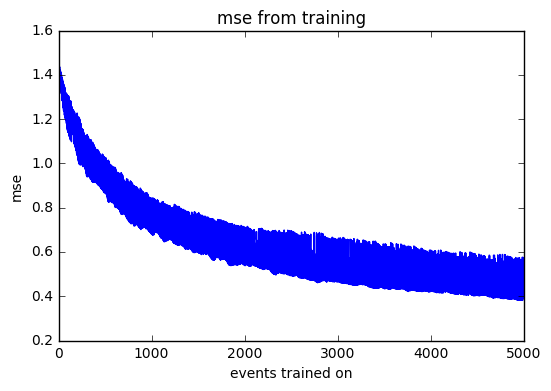

In [16]:
plt.plot(range(len(euclidean_errors)), euclidean_errors)
plt.title("mse from training")
plt.xlabel("events trained on")
plt.ylabel("mse")

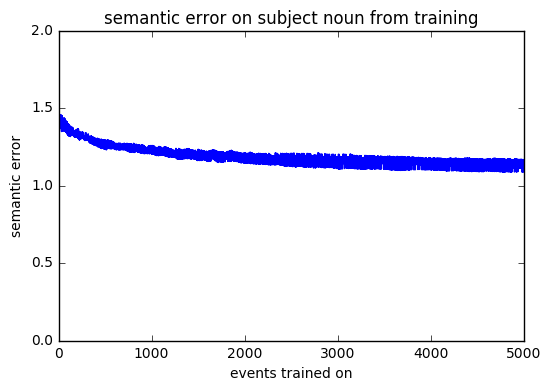

In [17]:
plt.plot(range(len(semantic_errors['subj_noun'])), semantic_errors['subj_noun'])
plt.ylim([0, 2])
plt.title("semantic error on subject noun from training")
plt.xlabel("events trained on")
plt.ylabel("semantic error")

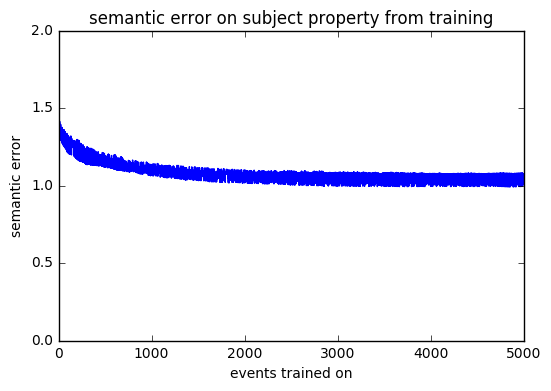

In [18]:
plt.plot(range(len(semantic_errors['subj_prop'])), semantic_errors['subj_prop'])
plt.ylim([0, 2])
plt.title("semantic error on subject property from training")
plt.xlabel("events trained on")
plt.ylabel("semantic error")

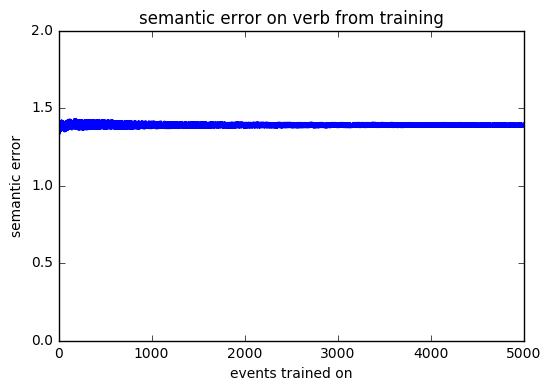

In [19]:
plt.plot(range(len(semantic_errors['verb'])), semantic_errors['verb'])
plt.ylim([0, 2])
plt.title("semantic error on verb from training")
plt.xlabel("events trained on")
plt.ylabel("semantic error")

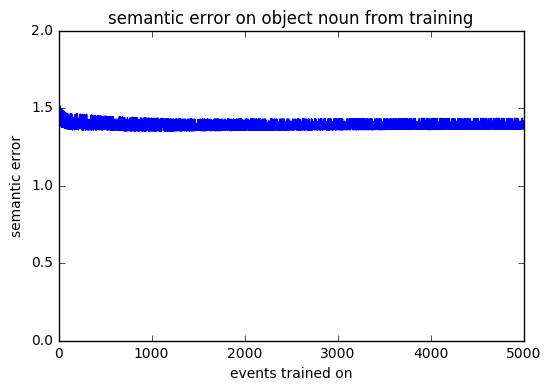

In [20]:
plt.plot(range(len(semantic_errors['obj_noun'])), semantic_errors['obj_noun'])
plt.ylim([0, 2])
plt.title("semantic error on object noun from training")
plt.xlabel("events trained on")
plt.ylabel("semantic error")

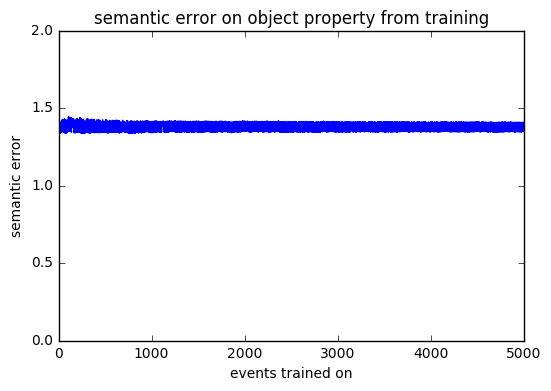

In [21]:
plt.plot(range(len(semantic_errors['obj_prop'])), semantic_errors['obj_prop'])
plt.ylim([0, 2])
plt.title("semantic error on object property from training")
plt.xlabel("events trained on")
plt.ylabel("semantic error")